# Exploring the Etsy Crepe Paper Flower Market

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

In [2]:
listings_main = pd.read_csv('nov_2020/listings_main.csv')
listings_materials = pd.read_csv('nov_2020/listings_materials.csv')
listings_style = pd.read_csv('nov_2020/listings_style.csv')
listings_tags = pd.read_csv('nov_2020/listings_tags.csv')
listings_taxonomy = pd.read_csv('nov_2020/listings_taxonomy.csv')

## Exploration Outline

[**1. Product Type Distribution**](#section1)
- Proportion of wedding and non-wedding products
- Proportion of pre-made and made-to-order products
- Crosstab analysis of product type and preparation
- Inference for population proportion of made to order products

[**2. Price Distribution**](#section2)
- Price distribution of all products
- Price distribution by product type
- Price distribution by preparation
- Price distribution of product type and preparation crosstab
 
[**3. Listing Trends**](#section3)
- Top five materials; Distribution of top 10 materials
- Top five styles; Distribution of top 10 styles
- Top five tags; Distribution of top 10 tags
- Top five taxonomies; Distribution of top 10 taxonomies
- Relationships between taxonomy, price, product type, and preparation
- Relationships between style, price, product type, and preparation

[**4. Price and Popularity Inferences**](#section4)
- Confidence interval of median prices for products by type
- Confidence interval of median prices for products by preparation
- Relationship between number of views and favorers and price
- Multivariate regression of number of views with price, type, and preparation

## 1. Product Type Distribution <a class="anchor" id="section1"></a>
### 1.1 Proportion of wedding and non-wedding products


In [3]:
# Create a new column to identify wedding products
wedding_products = listings_main['description'].str.contains('wedding', case=False, regex=True)
listings_main['weddings'] = wedding_products
listings_main.weddings.value_counts()

False    2682
True     1432
Name: weddings, dtype: int64

In [4]:
# Check
listings_main[listings_main.weddings == True].loc[:,'description']

7       bridal crepe paper bouquet that lasts a lifeti...
9       paper flowers for nursery wall decor will turn...
10      in stock now\n**please read details for sizing...
14      it would be perfect, stunning paper flower wil...
29      baby name sign with paper flowers wall decor a...
                              ...                        
4102    this listing is for a stem of crepe paper silv...
4103    this listing is for a single stem, light pink ...
4104    a single crepe paper tree peony handcrafted in...
4107    beautiful, realistic, crepe paper rose.  creat...
4109    it would be perfect, stunning paper flower wil...
Name: description, Length: 1432, dtype: object

In [5]:
# Compute percentage of product types
total = listings_main.shape[0]
wedding = listings_main.weddings.value_counts()[1]
non_wedding = listings_main.weddings.value_counts()[0]

print('{} percent of product listings are wedding products.'.format(round(wedding/total,3)*100))
print('{} percent of product listings are non-wedding products.'.format(round(non_wedding/total,3)*100))

34.8 percent of product listings are wedding products.
65.2 percent of product listings are non-wedding products.


''

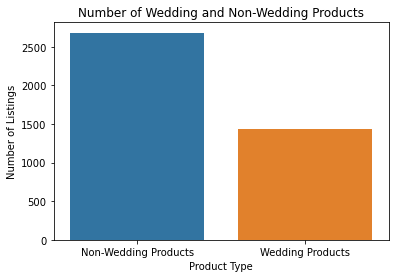

In [6]:
# Visualize percentage of product types
sb.countplot(data = listings_main, x = 'weddings')

plt.title('Number of Wedding and Non-Wedding Products')
plt.xticks(ticks = [0,1], labels = ['Non-Wedding Products', 'Wedding Products'])

plt.xlabel('Product Type')
plt.ylabel('Number of Listings')
;

### 1.2 Proportion of pre-made and made-to-order products


In [7]:
# Create a new simplified when_made column
when_made = []

for i in range(len(listings_main)):
    if listings_main['when_made'][i] == 'made_to_order':
        when_made.append('made to order')
    else:
        when_made.append('pre-made')

listings_main['when_made_simp'] = when_made

listings_main.when_made_simp.value_counts()

made to order    2190
pre-made         1924
Name: when_made_simp, dtype: int64

In [8]:
# Compute percentage of product preparations
total = listings_main.shape[0]
made_to_order = listings_main.when_made_simp.value_counts()[0]
pre_made = listings_main.when_made_simp.value_counts()[1]

print('{} percent of product listings are made-to-order.'.format(round(made_to_order/total,3)*100))
print('{} percent of product listings are pre-made.'.format(round(pre_made/total,3)*100))

53.2 percent of product listings are made-to-order.
46.800000000000004 percent of product listings are pre-made.


''

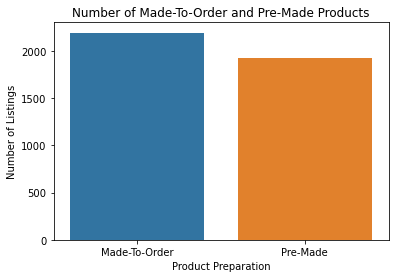

In [9]:
# Visualize percentage of product preparations
sb.countplot(data = listings_main, x = 'when_made_simp')

plt.title('Number of Made-To-Order and Pre-Made Products')
plt.xticks(ticks = [0,1], labels = ['Made-To-Order', 'Pre-Made'])

plt.xlabel('Product Preparation')
plt.ylabel('Number of Listings')
;

### 1.3 Crosstab analysis of product type and preparation

In [10]:
# Absolute crosstab
pd.crosstab(index = listings_main['weddings'], columns = listings_main['when_made_simp'])

when_made_simp,made to order,pre-made
weddings,,
False,1383,1299
True,807,625


In [11]:
# Percentage crosstab
pd.crosstab(index = listings_main['weddings'], columns = listings_main['when_made_simp'], normalize = True)*100

when_made_simp,made to order,pre-made
weddings,,
False,33.616918,31.575109
True,19.615946,15.192027


Ranked from most to least common listing type:
1. Made-to-order non-wedding products
2. Pre-made non-wedding products
3. Made-to-order wedding products
4. Pre-made wedding products

''

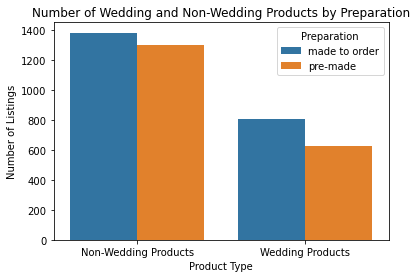

In [12]:
# Create a stacked bar chart of the above-described crosstab analysis.
sb.countplot(data = listings_main, x = 'weddings', hue = 'when_made_simp')
plt.title('Number of Wedding and Non-Wedding Products by Preparation')
plt.xticks(ticks = [0,1], labels = ['Non-Wedding Products', 'Wedding Products'])

plt.xlabel('Product Type')
plt.ylabel('Number of Listings')

plt.legend(title = "Preparation")
;

In [13]:
listings_main.columns

Index(['listing_id', 'user_id', 'title', 'description', 'price',
       'currency_code', 'quantity', 'url', 'views', 'num_favorers', 'who_made',
       'when_made', 'recipient', 'occasion', 'is_vintage', 'weddings',
       'when_made_simp'],
      dtype='object')

For both product types, made to order is the more popular preparation within listings.

### 1.4 Inference for population proportion of made to order products
The difference in percentages of made to order and pre-made products is small, so it warrants a statistical test to see if this difference is significant.

In [14]:
# One bootstrap resample of data
prep_boot = listings_main.sample(len(listings_main), replace = True)

total = prep_boot.shape[0]
made_to_order = prep_boot.when_made_simp.value_counts()[0]
pre_made = prep_boot.when_made_simp.value_counts()[1]

print('{} percent of product listings are made-to-order.'.format(round(made_to_order/total,3)*100))
print('{} percent of product listings are pre-made.'.format(round(pre_made/total,3)*100))

print('\n')
print('COUNT BY PREPARATION')
print(prep_boot.when_made_simp.value_counts())

53.2 percent of product listings are made-to-order.
46.800000000000004 percent of product listings are pre-made.


COUNT BY PREPARATION
made to order    2188
pre-made         1926
Name: when_made_simp, dtype: int64


<span style="color:red"> **BEFORE COMPLETING ANALYSIS, CHANGE RANGE BACK TO 10,000** </span>.

51.784759358288774 54.5940690325717


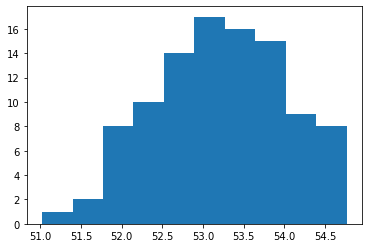

In [15]:
# 10,000 Bootstrap resample of data

boot_10k = []
for _ in range(100):
    sample = listings_main.sample(len(listings_main), replace = True)
    total = sample.shape[0]
    made_to_order = sample.when_made_simp.value_counts()[0]
    boot_10k.append((made_to_order/total)*100)

print(np.percentile(boot_10k,2.5),np.percentile(boot_10k,97.5))
plt.hist(boot_10k);

The confidence interval does not include 50% percent. So we can say that there is a 5% chance that the above range excludes the true population proportion of pre-made products. I.e. at a 95% confidence level, we can say that there are slightly more made-to-order products among listings.

## 2. Price Distribution<a class="anchor" id="section2"></a>
- 2.1 Price distribution of all products
- 2.2 Price distribution by product type
- 2.3 Price distribution by preparation
- 2.4 Price distribution of product type and preparation crosstab

### 2.1 Price distribution of all products

In [16]:
listings_main.price.describe()

count    4114.000000
mean       47.165399
std       129.507219
min         0.980000
25%        10.775000
50%        20.750000
75%        49.900000
max      4999.900000
Name: price, dtype: float64

In [17]:
print('The median price of all listings is {} USD.'.format(np.median(listings_main.price)))
print('The average price of all listings is {} USD.'.format(round(np.mean(listings_main.price),2)))

The median price of all listings is 20.75 USD.
The average price of all listings is 47.17 USD.


The average price is much higher than the median, suggesting heavily right-skewed price data.

''

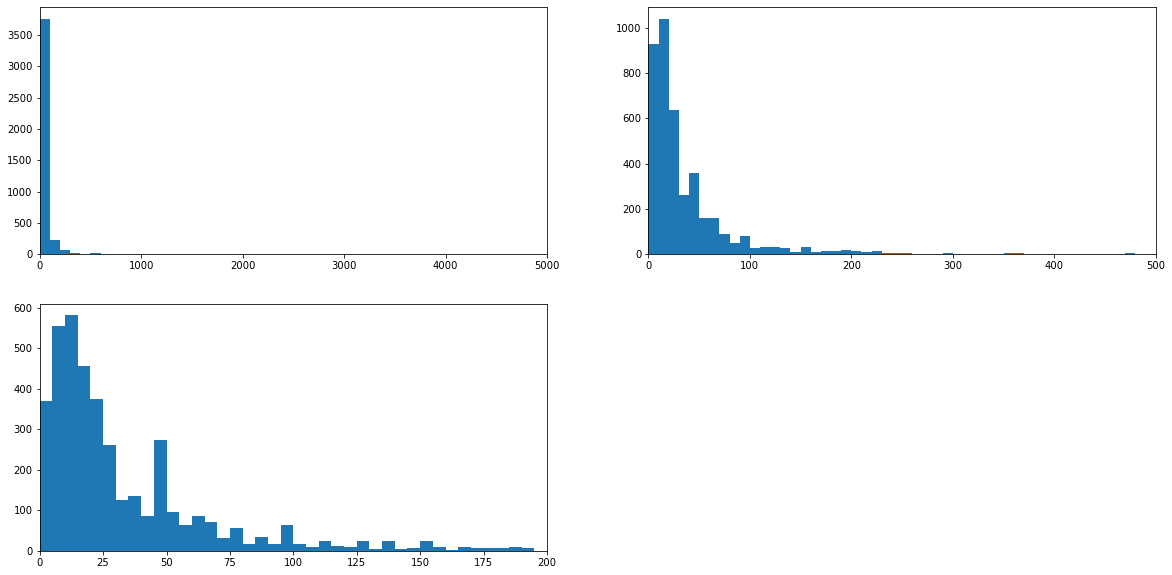

In [18]:
plt.figure(figsize = [20,10])

plt.subplot(2,2,1)
plt.hist(x = listings_main.price, bins = np.arange(0,5000,100))
plt.xlim(0,5000)

plt.subplot(2,2,2)
plt.hist(x = listings_main.price, bins = np.arange(0,500,10))
plt.xlim(0,500)

plt.subplot(2,2,3)
plt.hist(x = listings_main.price, bins = np.arange(0,200,5))
plt.xlim(0,200)

;

### 2.2 Price distribution by product type

In [19]:
# Wedding products
listings_main.query('weddings == True')['price'].describe()

count    1432.000000
mean       69.003799
std       198.491912
min         0.980000
25%        12.000000
50%        26.950000
75%        52.000000
max      4999.900000
Name: price, dtype: float64

In [20]:
# Non-wedding products
listings_main.query('weddings == False')['price'].describe()

count    2682.000000
mean       35.505224
std        65.653449
min         0.990000
25%         9.990000
50%        19.990000
75%        39.997500
max      2050.000000
Name: price, dtype: float64

In [21]:
print('The median price for wedding products is {} USD.'.format(np.median(listings_main.query('weddings == True')['price'])))
print('The mean price for wedding products is {} USD.'.format(np.mean(listings_main.query('weddings == True')['price'])))
print('\n')
print('The median price for non-wedding products is {} USD.'.format(np.median(listings_main.query('weddings == False')['price'])))
print('The mean price for non-wedding products is {} USD.'.format(np.mean(listings_main.query('weddings == False')['price'])))

The median price for wedding products is 26.95 USD.
The mean price for wedding products is 69.00379888268127 USD.


The median price for non-wedding products is 19.99 USD.
The mean price for non-wedding products is 35.505223713646814 USD.


''

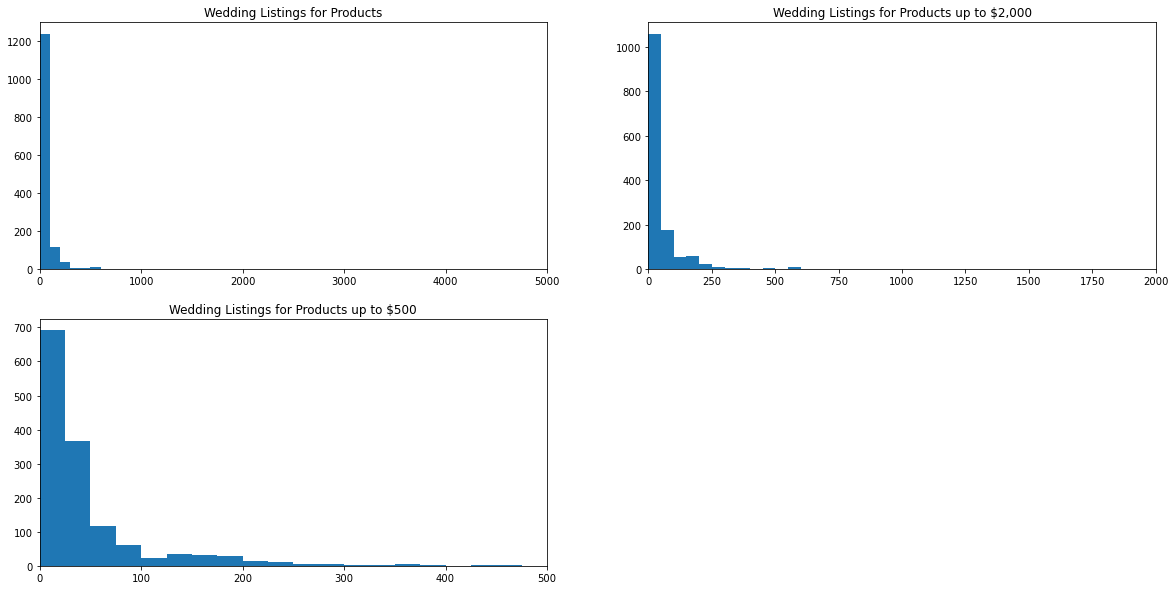

In [22]:
# Wedding Product Price Distribution

plt.figure(figsize = [20,10])

plt.subplot(2,2,1)
plt.hist(x = listings_main.query('weddings == True')['price'], bins = np.arange(0,5000,100))
plt.xlim(0,5000)
plt.title('Wedding Listings for Products')

plt.subplot(2,2,2)
plt.hist(x = listings_main.query('weddings == True')['price'], bins = np.arange(0,2000,50))
plt.xlim(0,2000)
plt.title('Wedding Listings for Products up to $2,000')

plt.subplot(2,2,3)
plt.hist(x = listings_main.query('weddings == True')['price'], bins = np.arange(0,500,25))
plt.xlim(0,500)
plt.title('Wedding Listings for Products up to $500')
;

''

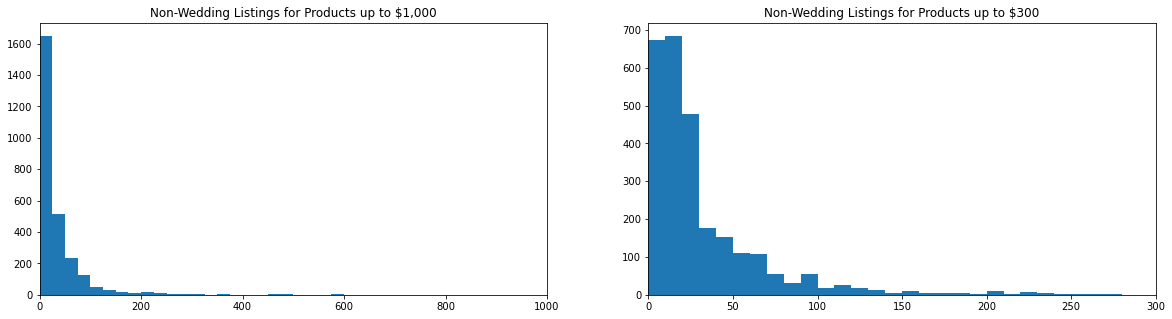

In [23]:
# Non-Wedding Product Price Distribution

plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
plt.hist(x = listings_main.query('weddings == False')['price'], bins = np.arange(0,1000,25))
plt.xlim(0,1000)
plt.title('Non-Wedding Listings for Products up to $1,000')

plt.subplot(1,2,2)
plt.hist(x = listings_main.query('weddings == False')['price'], bins = np.arange(0,300,10))
plt.xlim(0,300)
plt.title('Non-Wedding Listings for Products up to $300')
;

/Users/kristinafrazier/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

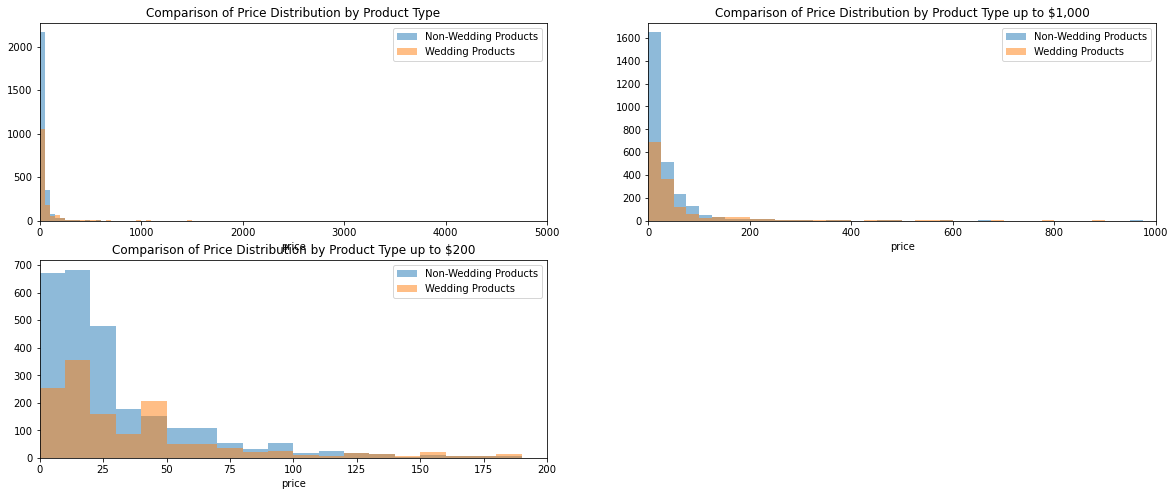

In [24]:
# Comparison of Price Distribution by Product Type

plt.figure(figsize = [20,8])

plt.subplot(2,2,1)
sb.distplot(listings_main.query('weddings == False')['price'], bins = np.arange(0,5000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('weddings == True')['price'], bins = np.arange(0,5000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,5000)
plt.legend(labels = ['Non-Wedding Products','Wedding Products'])
plt.title('Comparison of Price Distribution by Product Type')


plt.subplot(2,2,2)

sb.distplot(listings_main.query('weddings == False')['price'], bins = np.arange(0,1000,25), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('weddings == True')['price'], bins = np.arange(0,1000,25), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,1000)
plt.legend(labels = ['Non-Wedding Products','Wedding Products'])
plt.title('Comparison of Price Distribution by Product Type up to $1,000')


plt.subplot(2,2,3)

sb.distplot(listings_main.query('weddings == False')['price'], bins = np.arange(0,200,10), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('weddings == True')['price'], bins = np.arange(0,200,10), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,200)
plt.legend(labels = ['Non-Wedding Products','Wedding Products'])
plt.title('Comparison of Price Distribution by Product Type up to $200')
;

### 2.3 Price distribution by preparation

In [25]:
listings_main.query('when_made_simp == "made to order"')['price'].describe()

count    2190.000000
mean       63.752027
std       171.416523
min         1.990000
25%        15.125000
50%        26.900000
75%        55.990000
max      4999.900000
Name: price, dtype: float64

In [26]:
listings_main.query('when_made_simp == "pre-made"')['price'].describe()

count    1924.000000
mean       28.285608
std        41.891491
min         0.980000
25%         6.990000
50%        14.000000
75%        35.000000
max       650.000000
Name: price, dtype: float64

In [27]:
print('The median price for made to order products is {} USD.'.format(np.median(listings_main.query('when_made_simp == "made to order"')['price'])))
print('The mean price for made to order products is {} USD.'.format(np.mean(listings_main.query('when_made_simp == "made to order"')['price'])))
print('\n')
print('The median price for pre-made products is {} USD.'.format(np.median(listings_main.query('when_made_simp == "pre-made"')['price'])))
print('The mean price for pre-made products is {} USD.'.format(np.mean(listings_main.query('when_made_simp == "pre-made"')['price'])))

The median price for made to order products is 26.9 USD.
The mean price for made to order products is 63.752027397260555 USD.


The median price for pre-made products is 14.0 USD.
The mean price for pre-made products is 28.28560810810809 USD.


/Users/kristinafrazier/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/kristinafrazier/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


''

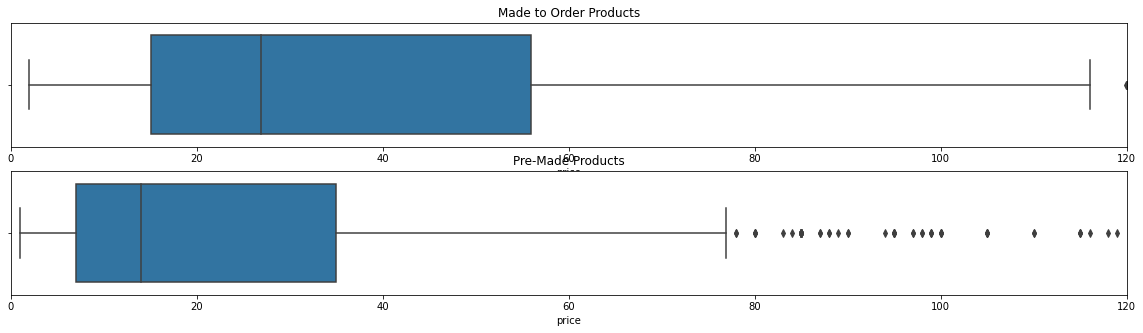

In [28]:
plt.figure(figsize = [20,5])

plt.subplot(2,1,1)
sb.boxplot(listings_main.query('when_made_simp == "made to order"')['price'])
plt.xlim(0,120)
plt.title('Made to Order Products')


plt.subplot(2,1,2)
sb.boxplot(listings_main.query('when_made_simp == "pre-made"')['price'])
plt.xlim(0,120)
plt.title('Pre-Made Products')

;

/Users/kristinafrazier/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

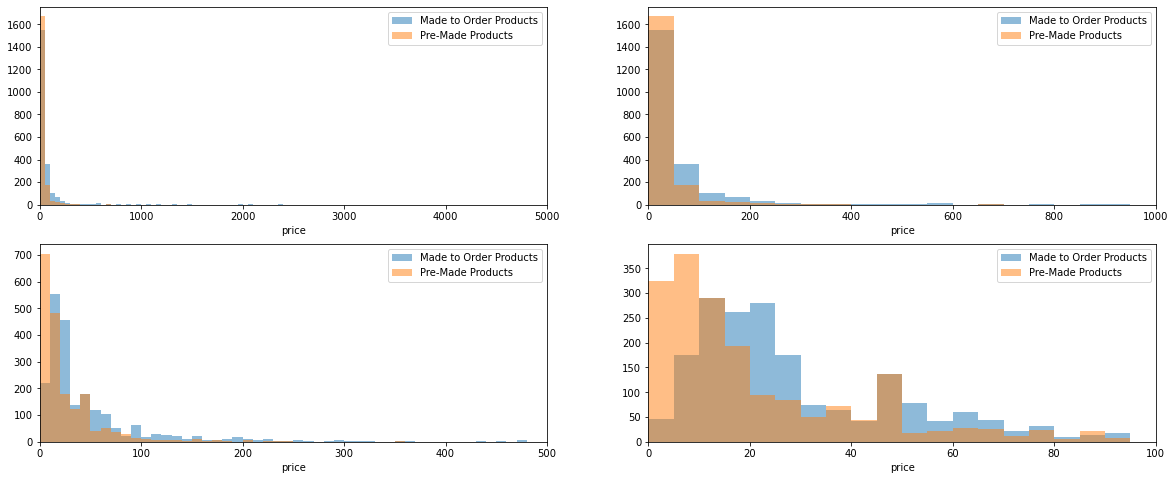

In [29]:
plt.figure(figsize = [20,8])

plt.subplot(2,2,1)
sb.distplot(listings_main.query('when_made_simp == "made to order"')['price'], bins = np.arange(0,5000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('when_made_simp == "pre-made"')['price'], bins = np.arange(0,5000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,5000)
plt.legend(labels = ['Made to Order Products','Pre-Made Products'])

plt.subplot(2,2,2)
sb.distplot(listings_main.query('when_made_simp == "made to order"')['price'], bins = np.arange(0,1000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('when_made_simp == "pre-made"')['price'], bins = np.arange(0,1000,50), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,1000)
plt.legend(labels = ['Made to Order Products','Pre-Made Products'])

plt.subplot(2,2,3)
sb.distplot(listings_main.query('when_made_simp == "made to order"')['price'], bins = np.arange(0,500,10), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('when_made_simp == "pre-made"')['price'], bins = np.arange(0,500,10), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,500)
plt.legend(labels = ['Made to Order Products','Pre-Made Products'])

plt.subplot(2,2,4)
sb.distplot(listings_main.query('when_made_simp == "made to order"')['price'], bins = np.arange(0,100,5), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[0])
sb.distplot(listings_main.query('when_made_simp == "pre-made"')['price'], bins = np.arange(0,100,5), kde = False,
            hist_kws = {'alpha' : 0.5}, color = sb.color_palette()[1])
plt.xlim(0,100)
plt.legend(labels = ['Made to Order Products','Pre-Made Products'])
;

### 2.4 Price distribution of product type and preparation crosstab

''

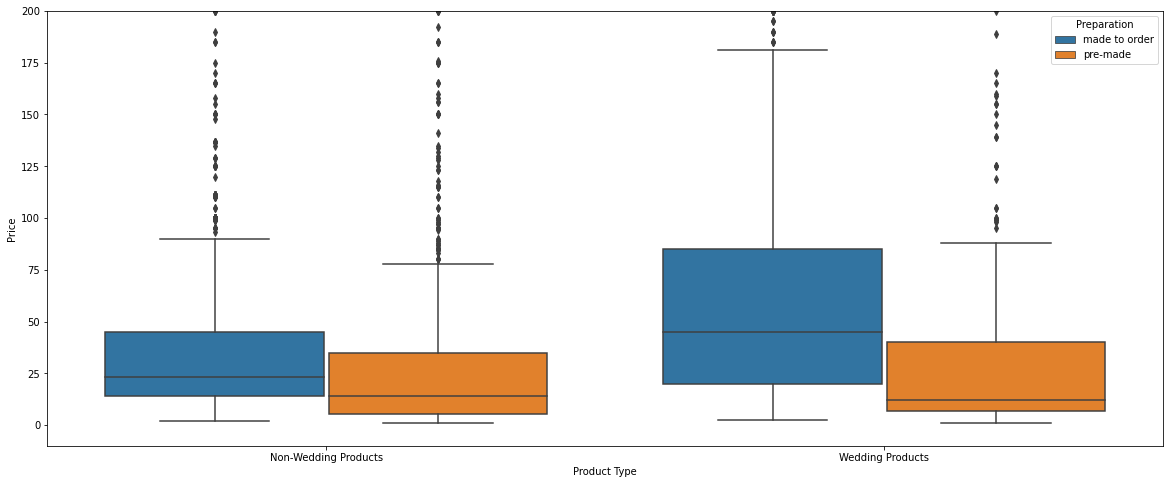

In [30]:
plt.figure(figsize = [20,8])

sb.boxplot(data = listings_main, x = 'weddings', y = 'price', hue = 'when_made_simp')

plt.ylim(-10,200)

plt.legend(title = 'Preparation')

plt.xlabel('Product Type')
plt.ylabel('Price')

plt.xticks(ticks = [0,1], labels = ['Non-Wedding Products', 'Wedding Products'])

;

## 3. Listing Trends<a class="anchor" id="section3"></a>
- 3.1 Top five materials; Distribution of top 10 materials
- 3.2 Top five styles; Distribution of top 10 styles
- 3.3 Top five tags; Distribution of top 10 tags
- 3.4 Top five taxonomies; Distribution of top 10 taxonomies
- 3.5 Relationships between taxonomy, price, product type, and preparation
- 3.6 Relationships between style, price, product type, and preparation

### 3.1 Top Materials

In [31]:
top_10_mat = listings_materials['materials'].value_counts()[:10]
top_10_mat

crepe paper             2352
wire                     978
paper                    746
glue                     463
italian crepe paper      190
floral tape              180
floral wire              177
crepe paper flowers      116
metal stems              112
paper flower bouquet     111
Name: materials, dtype: int64

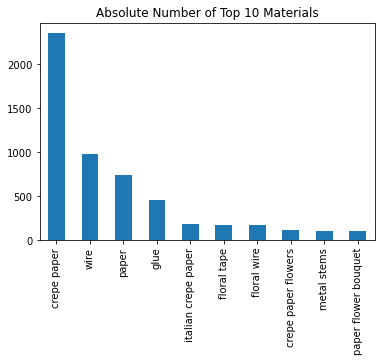

In [32]:
(top_10_mat).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 10 Materials');

### 3.2 Top Styles

In [33]:
top_10_style = listings_style['style'].value_counts()[:10]
top_10_style

traditional        564
cottage chic       536
retro              305
modern             189
rustic             148
boho               140
art deco           104
cовременный         60
неоклассический     60
victorian           42
Name: style, dtype: int64

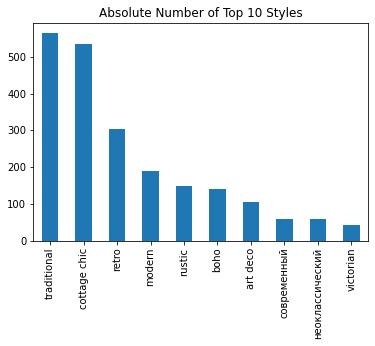

In [34]:
(top_10_style).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 10 Styles');

### 3.3 Top Tags

In [35]:
top_10_tags = listings_tags['tags'].value_counts()[:10]
top_10_tags

crepe paper flowers    1593
crepe paper            1455
paper flowers          1317
mexican flowers         765
crepe paper flower      545
cinco de mayo           535
day of the dead         447
party decorations       424
dia de los muertos      412
wedding decorations     389
Name: tags, dtype: int64

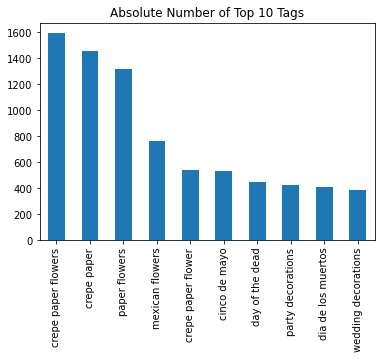

In [36]:
(top_10_tags).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 10 Tags');

### 3.4 Top Taxonomies

In [37]:
top_10_tax = listings_taxonomy['taxonomy_path'].value_counts()[:10]
top_10_tax

paper & party supplies    1106
weddings                  1021
home & living              965
home décor                 947
craft supplies & tools     784
accessories                753
bouquets & corsages        705
bouquets                   686
party supplies             644
party décor                573
Name: taxonomy_path, dtype: int64

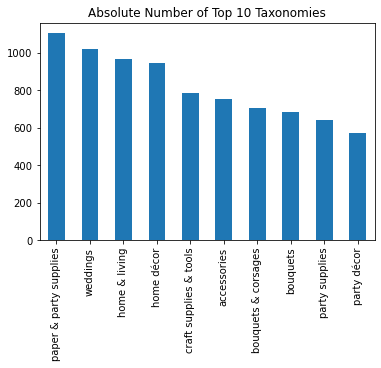

In [38]:
(top_10_tax).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 10 Taxonomies');

### 3.5 Relationships between taxonomy, price, product type, and preparation

- For the top 5 most popular taxonomies of all listings, what percentage are wedding products, and what percentage are made-to-order? (normalize within each taxonomy? normalize across all taxonomies??)
- What is the mean product price of products by taxonomies? What are the top 5 highest-priced taxonomies?


''

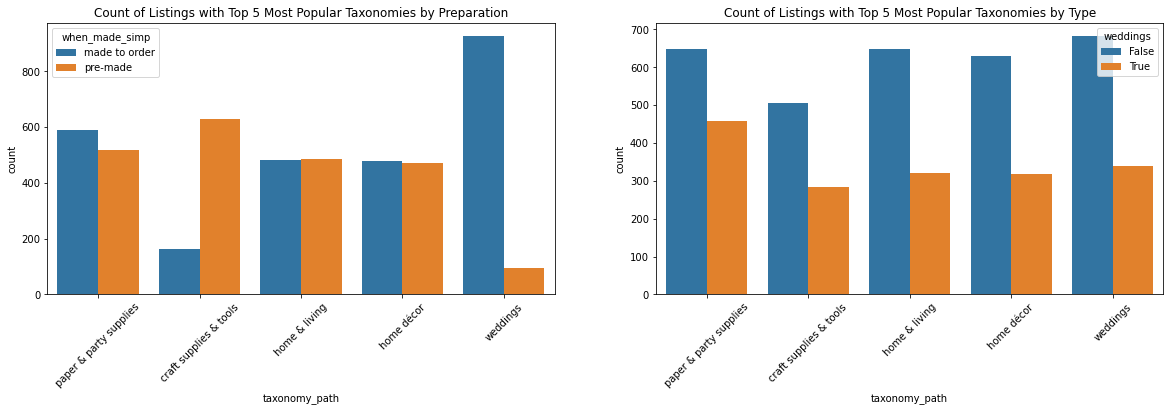

In [39]:
# Create a simplified dataframe linking taxonomy with other variables of interest by dropping columns from the
# main listings table and merging the data to the taxonomy table
listings = listings_main.drop([ 'user_id', 'title', 'description',
       'currency_code', 'quantity', 'url', 'views', 'num_favorers', 'who_made',
       'when_made', 'recipient', 'occasion', 'is_vintage'], axis = 1)

tax_rel = listings_taxonomy.merge(right = listings, how = 'left', on = 'listing_id')

# Instantiate into a list the top 5 taxnomies for use in a for loop function to create a subset of tax_rel of 
# only listings including the top 5 taxonomies
top_5_tax = list(tax_rel.taxonomy_path.value_counts()[:5].to_frame().index)

tax_rel_top5 = tax_rel.drop(labels = range(len(tax_rel))).copy()
tax_rel_top5

for i in range(len(tax_rel)):
    if (tax_rel['taxonomy_path'][i] in top_5_tax) == True:
        tax_rel_top5 = tax_rel_top5.append(tax_rel.iloc[i,:], ignore_index = True)
        
# Plot the results
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
sb.countplot(x = 'taxonomy_path', data = tax_rel_top5, hue  = 'when_made_simp')
plt.title('Count of Listings with Top 5 Most Popular Taxonomies by Preparation')
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sb.countplot(x = 'taxonomy_path', data = tax_rel_top5, hue  = 'weddings')
plt.title('Count of Listings with Top 5 Most Popular Taxonomies by Type')
plt.xticks(rotation = 45)
;

''

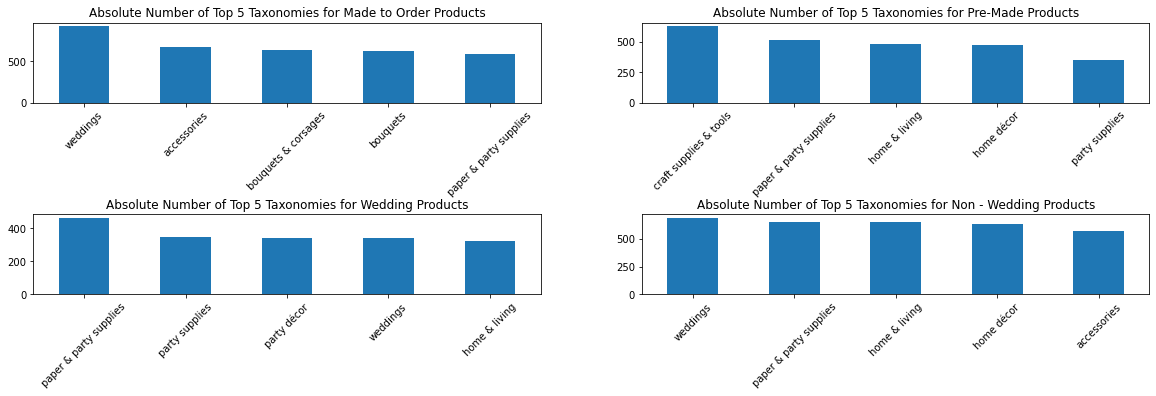

In [40]:
# Top 5 taxonomies by Preparation and Type
plt.figure(figsize = [20,5])

plt.subplot(3,2,1)
top_5_tax_mto = tax_rel.query('when_made_simp == "made to order"')['taxonomy_path'].value_counts()[:5]
(top_5_tax_mto).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Made to Order Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,2)
top_5_tax_pm = tax_rel.query('when_made_simp == "pre-made"')['taxonomy_path'].value_counts()[:5]
(top_5_tax_pm).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Pre-Made Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,5)
top_5_tax_pm = tax_rel.query('weddings == True')['taxonomy_path'].value_counts()[:5]
(top_5_tax_pm).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Wedding Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,6)
top_5_tax_nw = tax_rel.query('weddings == False')['taxonomy_path'].value_counts()[:5]
(top_5_tax_nw).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Non - Wedding Products')
plt.xticks(rotation = 45)

;

In [41]:
# Average price of all taxonomies
tax_rel.groupby('taxonomy_path')['price'].mean().sort_values(ascending = False)

taxonomy_path
wall stencils              200.000000
plants                     185.861176
art & photography books    150.000000
decorations                142.705379
dresses                    122.000000
                              ...    
washi tape                   2.000000
glue & adhesives             2.000000
drawing & illustration       1.865714
digital                      1.865714
confetti                     1.500000
Name: price, Length: 215, dtype: float64

### 3.6 Relationships between style, price, product type, and preparation


In [ ]:
# Instantiate into a list the top 5 styles for use in a for loop function to create a subset of tax_rel of 
# only listings including the top 5 styles
style_rel = listings_style.merge(right = listings, how = 'left', on = 'listing_id')

top_5_style = list(style_rel['style'].value_counts()[:5].to_frame().index)

style_rel_top5 = style_rel.drop(labels = range(len(style_rel))).copy()

for i in range(len(style_rel)):
    if (style_rel['style'][i] in top_5_style) == True:
        style_rel_top5 = style_rel_top5.append(style_rel.iloc[i,:], ignore_index = True)
        
# Plot the results
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
sb.countplot(x = 'style', data = style_rel_top5, hue  = 'when_made_simp')
plt.title('Count of Listings with Top 5 Most Popular Styles by Preparation')
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sb.countplot(x = 'style', data = style_rel_top5, hue  = 'weddings')
plt.title('Count of Listings with Top 5 Most Popular Styles by Type')
plt.xticks(rotation = 45);

In [ ]:
# Top 5 Styles by Preparation and Type
plt.figure(figsize = [20,5])

plt.subplot(3,2,1)
top_5_tax_mto = tax_rel.query('when_made_simp == "made to order"')['taxonomy_path'].value_counts()[:5]
(top_5_tax_mto).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Made to Order Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,2)
top_5_tax_pm = tax_rel.query('when_made_simp == "pre-made"')['taxonomy_path'].value_counts()[:5]
(top_5_tax_pm).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Pre-Made Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,5)
top_5_tax_pm = tax_rel.query('weddings == True')['taxonomy_path'].value_counts()[:5]
(top_5_tax_pm).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Wedding Products')
plt.xticks(rotation = 45)


plt.subplot(3,2,6)
top_5_tax_nw = tax_rel.query('weddings == False')['taxonomy_path'].value_counts()[:5]
(top_5_tax_nw).plot(kind='bar', legend=None)
plt.title('Absolute Number of Top 5 Taxonomies for Non - Wedding Products')
plt.xticks(rotation = 45)

;

In [ ]:
# Average price of all taxonomies
tax_rel.groupby('taxonomy_path')['price'].mean().sort_values(ascending = False)

## 4. Price Inference<a class="anchor" id="section4"></a>

- 4.1 Confidence interval of median prices for products by type
- 4.2 Confidence interval of median prices for products by preparation
- 4.3 Relationship between number of views and favorers and price
- 4.4 Multivariate regression of number of views with price, type, and preparation

### 4.1 Confidence interval of median prices for products by type

In [ ]:
print('The median price for wedding products is {} USD.'.format(np.median(listings_main.query('weddings == True')['price'])))
print('The median price for non-wedding products is {} USD.'.format(np.median(listings_main.query('weddings == False')['price'])))
print('The median price for made to order products is {} USD.'.format(np.median(listings_main.query('when_made_simp == "made to order"')['price'])))
print('The median price for pre-made products is {} USD.'.format(np.median(listings_main.query('when_made_simp == "pre-made"')['price'])))

In [ ]:
# Testing a SciPy Quantile Confidence Interval method: This is the very first time I have attempted a 
# Quantile Confidence Interval, so I'm checking the SciPi method against the example displayed in this dataset: 
# https://www.statsdirect.com/help/nonparametric_methods/quantile_ci.htm

test =[46.9,47.2,49.1,56.5,56.8,59.2,59.9,63.2,63.3,63.4,63.7,64.1,67.1,67.7,73.3,78.5]

p_75 = np.percentile(a = test, q = 75)
print('The 75th percentile of this dataset is {}.'.format(p_75))


p_75_ci = stats.mstats.mquantiles_cimj(data = test, prob = [.75], alpha = 0.10)
print('The confidence interval for the 75th percentile of this dataset is {}.'.format(p_75_ci))

In [ ]:
# The above-method tracks with the linked example (although the difference in the interval appears to be due to
# the difference in calculation of the median of the dataset). So, the below code uses the same SciPy model
# on the Etsy dataset

p_50_weddings = np.percentile(a = listings_main.query('weddings == True')['price'], q = 50)
print('The median price of wedding products is {}.'.format(p_50_weddings))


p_50_weddings_ci = stats.mstats.mquantiles_cimj(data = listings_main.query('weddings == True')['price'], prob = [.50], alpha = 0.05)
print('The 95% confidence interval for the median of this dataset is {}.'.format(p_50_weddings_ci))

p_50_non_weddings = np.percentile(a = listings_main.query('weddings == False')['price'], q = 50)
print('The median price of wedding products is {}.'.format(p_50_non_weddings))


p_50_non_weddings_ci = stats.mstats.mquantiles_cimj(data = listings_main.query('weddings == False')['price'], prob = [.50], alpha = 0.05)
print('The 95% confidence interval for the median of this dataset is {}.'.format(p_50_non_weddings_ci))

Because there is a slight overlap in the 95 percent confidence intervals of the median prices for these products, we can't be sure that for all listings the median prices aren't the same.

### 4.2 Confidence interval of median prices for products by preparation

In [ ]:
p_50_made = np.percentile(a = listings_main.query('when_made_simp == "made to order"')['price'], q = 50)
print('The median price of wedding products is {}.'.format(p_50_made))


p_50_made_ci = stats.mstats.mquantiles_cimj(data = listings_main.query('when_made_simp == "made to order"')['price'], prob = [.50], alpha = 0.05)
print('The 95% confidence interval for the median of this dataset is {}.'.format(p_50_made_ci))

p_50_prep = np.percentile(a = listings_main.query('when_made_simp == "pre-made"')['price'], q = 50)
print('The median price of wedding products is {}.'.format(p_50_prep))


p_50_prep_ci = stats.mstats.mquantiles_cimj(data = listings_main.query('when_made_simp == "pre-made"')['price'], prob = [.50], alpha = 0.05)
print('The 95% confidence interval for the median of this dataset is {}.'.format(p_50_prep_ci))

With 95 percent confidence, we can say that there is a median price difference by preparation type.

### 4.3 Relationship between number of views and favorers and price

In [ ]:
# Scatter Plot
listings_main.columns

In [ ]:
plt.figure(figsize=[10,5])

plt.subplot(2,2,1)
sb.scatterplot(data=listings_main, x="num_favorers", y="price")

plt.subplot(2,2,2)
sb.scatterplot(data=listings_main, x="views", y="price")

plt.subplot(2,2,3)
sb.scatterplot(data=listings_main, x="views", y="num_favorers");

There are no strong correlations between views, number of favorers, and price among the listings.

### 4.4 Multivariate regression of number of views with price, type, and preparation

In [ ]:
# Set intercept for regression
listings_main['intercept'] = 1

# Get dummies of categorical variables
weddings = pd.get_dummies(listings_main['weddings'])
preparation = pd.get_dummies(listings_main['when_made_simp'])

# Add dummy variables to main data table
main_new = listings_main.join(weddings)
main_new = main_new.join(preparation)

# Rename True and False boolean column names for wedding and non-wedding products
main_new = main_new.rename(columns = {False: 'Non-Weddings',True:'Weddings'})

# Fit and display model results
model = sm.OLS(main_new['views'],main_new[['intercept','Non-Weddings','Weddings','made to order','pre-made']]).fit()
model.summary()

Because the R-square value is so low, we can say that the number of views that listing gets cannot be modeled by these variables alone. This model was an attempt to see what attributes of a listing increases the likelihood of a listing getting more views. The variables that we have in this dataset are apparently not strong predictors of view count.